# Construct the training data into Data format

In [1]:
import sys
sys.path.append("../src")

import torch
import pandas as pd
import numpy as np
from ast import literal_eval
from collections import Counter
from torch_geometric.data import Data
from reachability_model_function import build_graph_reachability
from dataset_function import generate_labeled_route_no_sides
from torch_geometric.loader import DataLoader
from reachability_model_function import ReachabilityGNN
from sklearn.model_selection import  train_test_split
from sklearn.metrics import classification_report
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from reachability_model_function import FocalLoss
from reachability_model_function import plot_graph_prediction
from torch_geometric.data import Batch
from reachability_model_function import simulate_climb_to_goal, recompute_node_features_with_climber

In [2]:
dataset = pd.read_csv("../data/reachability_dataset.csv")

In [3]:
for name in dataset.columns:
    dataset[name] = dataset[name].apply(literal_eval)

In [4]:
# graph_list: each graph is a training sample
graph_list = []

for _, row in dataset.iterrows():
    labels = generate_labeled_route_no_sides(row["route"], row["hands"], row["feet"], row["climber"])
    if labels.count(0) / len(labels) < 0.95:
        data = build_graph_reachability(row["route"], row["hands"], row["feet"], row["climber"], labels)
        graph_list.append(data)

In [5]:
len(graph_list)

89898

In [6]:
# Save the graph_list to local
torch.save(graph_list, "graph_list_global4.pt")

# Train the Model

In [7]:
# Load pt file
graph_list = torch.load("graph_list_global4.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_8148\4095728735.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_list = torch.load("graph_list_global4.pt")


In [8]:
graph_list[0]

Data(x=[76, 8], edge_index=[2, 420], y=[76], climber=[1, 4], hands=[2, 2], feet=[2, 2])

In [9]:
train_data, test_data = train_test_split(graph_list, test_size=0.2, random_state=42)

In [10]:
# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [ ]:
all_labels = torch.cat([g.y for g in train_data])
counts = Counter(all_labels.tolist())
total = sum(counts.values())

max_cap = 5
weights = [min(np.log(total / (counts.get(i, 1) + 1)), max_cap) for i in range(4)]
weights = torch.tensor(weights, dtype=torch.float)

print("Used Weights:", weights)

Used Weights: tensor([0.3115, 1.8765, 5.0000, 2.1835])


# Use Balanced

In [11]:
all_train_labels = []
for g in train_data:
    all_train_labels.extend(g.y.cpu().numpy())  

classes = np.unique(all_train_labels)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=all_train_labels)

weights = np.clip(weights, a_min=None, a_max=5.0)
weights = torch.tensor(weights, dtype=torch.float).to(device)

print("Balanced weights:", weights)

Balanced weights: tensor([0.3414, 1.6327, 5.0000, 2.2193], device='cuda:0')


In [12]:
# shuffle=True: Shuffle the order of the graph at each epoch to enhance the model's generalisation ability.
loader = DataLoader(train_data, batch_size=8, shuffle=True)
model = ReachabilityGNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

# CrossEntropy
# loss_fn = nn.CrossEntropyLoss(weight=weights)

# Focal Loss
loss_fn = FocalLoss(gamma=2.0, weight=weights)


for epoch in range(50):
    total_loss = 0
    model.train()
    for batch in loader:
        batch = batch.to(device)
        out = model(batch)
        loss = loss_fn(out, batch.y)
        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()  # learning rate decay
    current_lr = scheduler.get_last_lr()[0]   
    print(f"Epoch {epoch:02d} | Loss: {total_loss:.4f} | LR: {current_lr:.5f} | LossFn: {loss_fn.__class__.__name__}")

Epoch 00 | Loss: 67102.1783 | LR: 0.00100 | LossFn: FocalLoss
Epoch 01 | Loss: 3312.7759 | LR: 0.00100 | LossFn: FocalLoss
Epoch 02 | Loss: 3309.5228 | LR: 0.00100 | LossFn: FocalLoss
Epoch 03 | Loss: 3306.5841 | LR: 0.00100 | LossFn: FocalLoss
Epoch 04 | Loss: 4443.0066 | LR: 0.00100 | LossFn: FocalLoss
Epoch 05 | Loss: 3307.2307 | LR: 0.00100 | LossFn: FocalLoss
Epoch 06 | Loss: 3305.0515 | LR: 0.00100 | LossFn: FocalLoss
Epoch 07 | Loss: 3307.9773 | LR: 0.00100 | LossFn: FocalLoss
Epoch 08 | Loss: 3308.2839 | LR: 0.00100 | LossFn: FocalLoss
Epoch 09 | Loss: 3307.2693 | LR: 0.00100 | LossFn: FocalLoss
Epoch 10 | Loss: 3307.7064 | LR: 0.00100 | LossFn: FocalLoss
Epoch 11 | Loss: 3306.5468 | LR: 0.00100 | LossFn: FocalLoss
Epoch 12 | Loss: 3305.2848 | LR: 0.00100 | LossFn: FocalLoss
Epoch 13 | Loss: 3305.2122 | LR: 0.00100 | LossFn: FocalLoss
Epoch 14 | Loss: 3305.0679 | LR: 0.00050 | LossFn: FocalLoss
Epoch 15 | Loss: 3305.6148 | LR: 0.00050 | LossFn: FocalLoss
Epoch 16 | Loss: 3304.6

In [13]:
model.eval()
all_preds = []

with torch.no_grad():
    for g in train_data:
        batch = Batch.from_data_list([g]).to(device)     
        out = model(batch)                    
        pred = out.argmax(dim=1)
        all_preds.extend(pred.tolist())

print("Distribution of Predictions:", Counter(all_preds))

Distribution of Predictions: Counter({1: 6828150, 3: 292164})


In [14]:
torch.save(model.state_dict(),"reachability_model12.pt")

# Visualisation

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
# Load the model
model = ReachabilityGNN().to(device)
model.load_state_dict(torch.load("reachability_model12.pt"))
model.eval()

C:\Users\guanj\AppData\Local\Temp\ipykernel_8148\4273644490.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("reachability_model12.pt"))


ReachabilityGNN(
  (lin_in): Linear(in_features=6, out_features=64, bias=True)
  (conv1): GATConv(64, 64, heads=2)
  (conv2): GATConv(64, 64, heads=2)
  (climber_embed): Linear(in_features=4, out_features=64, bias=True)
  (film1): Linear(in_features=64, out_features=128, bias=True)
  (film2): Linear(in_features=64, out_features=128, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=4, bias=True)
  )
  (flag_head): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [16]:
graph_list = torch.load("graph_list_global4.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_8148\1638807745.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_list = torch.load("graph_list_global4.pt")


In [17]:
train_data, test_data = train_test_split(graph_list, test_size=0.2, random_state=42)

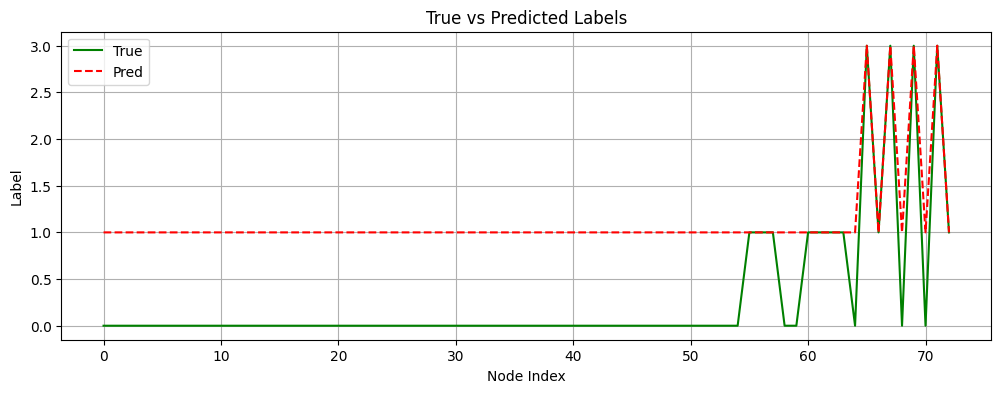

In [18]:
import matplotlib.pyplot as plt
from torch_geometric.data import Batch
graph = test_data[2450]
batch = Batch.from_data_list([graph])
batch = batch.to(device)

with torch.no_grad():
    pred_logits = model(batch)
    pred_labels = pred_logits.argmax(dim=1)

# 转 numpy
true = graph.y.cpu().numpy()
pred = pred_labels.cpu().numpy()

# 绘图
plt.figure(figsize=(12, 4))
plt.plot(true, label='True', color='green')
plt.plot(pred, label='Pred', linestyle='--', color='red')
plt.legend()
plt.title("True vs Predicted Labels")
plt.xlabel("Node Index")
plt.ylabel("Label")
plt.grid(True)
plt.show()

In [ ]:
all_preds, all_trues = [], []
model.eval()
with torch.no_grad():
    for g in test_data:
        batch = Batch.from_data_list([g])  
        batch = batch.to(device)
        out = model(batch)
        pred = out.argmax(dim=1).cpu().numpy()
        true = batch.y.cpu().numpy()
        all_preds.extend(pred)
        all_trues.extend(true)

print(classification_report(all_trues, all_preds, target_names=["unreachable", "hand", "foot", "both"]))

# Visualise the Model Output

In [ ]:
graph_list = torch.load("graph_list_global3.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_8148\3638643281.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_list = torch.load("graph_list_global3.pt")


In [21]:
train_data, test_data = train_test_split(graph_list, test_size=0.2, random_state=42)

In [ ]:
model = ReachabilityGNN()
model.load_state_dict(torch.load("reachability_model12.pt"))

C:\Users\guanj\AppData\Local\Temp\ipykernel_8148\1083466364.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("reachability_model11.pt"))


RuntimeError: Error(s) in loading state_dict for ReachabilityGNN:
	Missing key(s) in state_dict: "lin_in.weight", "lin_in.bias", "film1.weight", "film1.bias", "film2.weight", "film2.bias". 
	size mismatch for conv1.lin.weight: copying a param with shape torch.Size([128, 8]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for classifier.0.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([64, 64]).

In [17]:
graph.climber

tensor([[168.3000,   1.0100,   4.0000,   0.5030]])

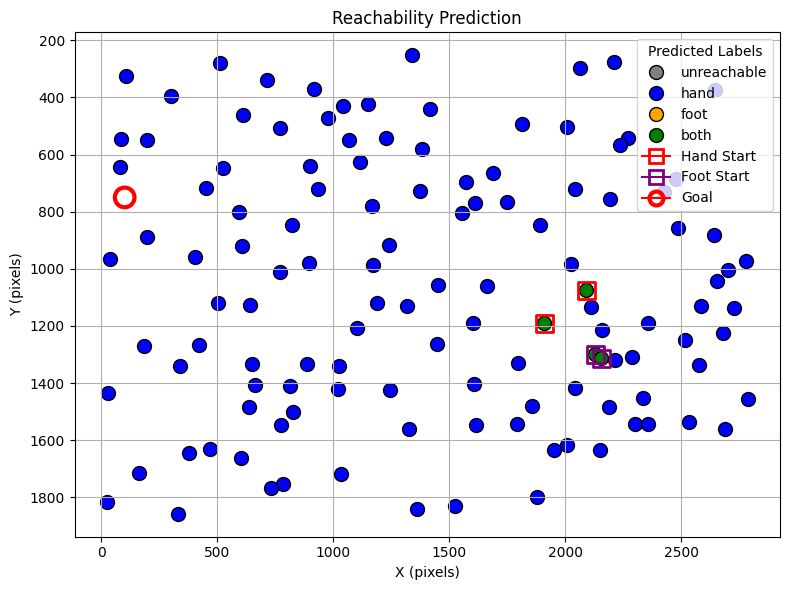

In [22]:
graph = test_data[10222]
import copy
g = copy.deepcopy(graph)
g.climber = torch.tensor([[150.4000, 1.0500, 4.0000, 0.5193]])
recompute_node_features_with_climber(g)

batch = Batch.from_data_list([g])
plot_graph_prediction(batch, model, "Reachability Prediction", (100, 750))

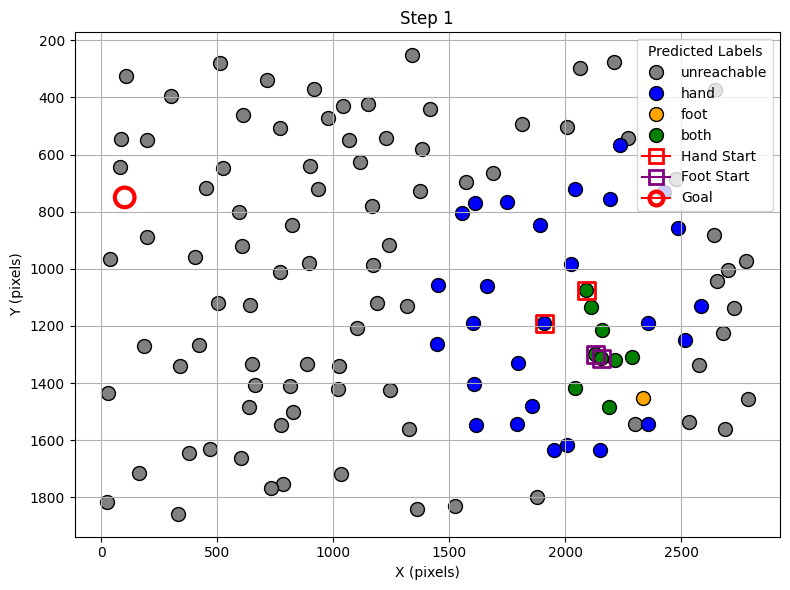

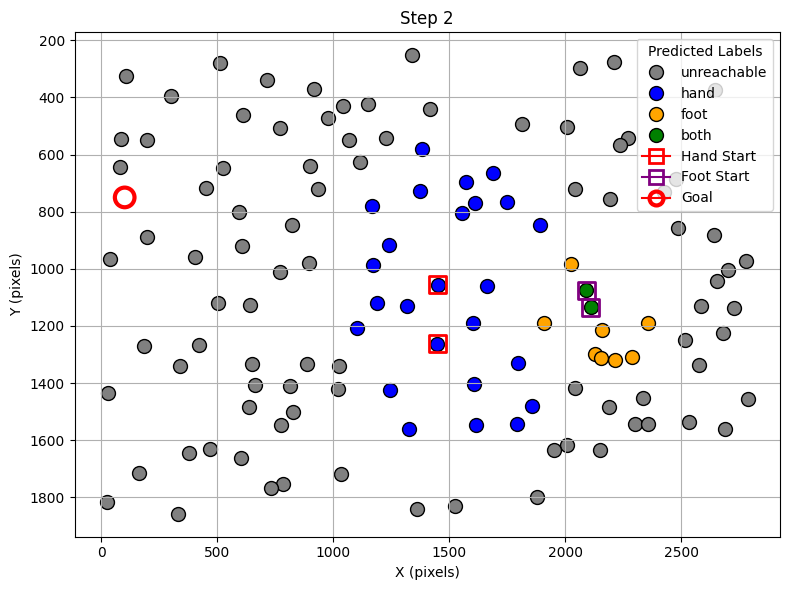

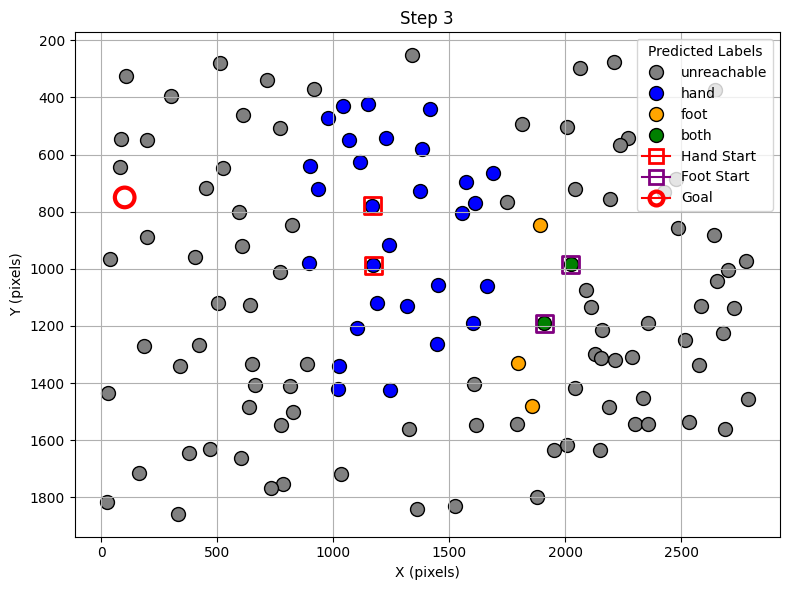

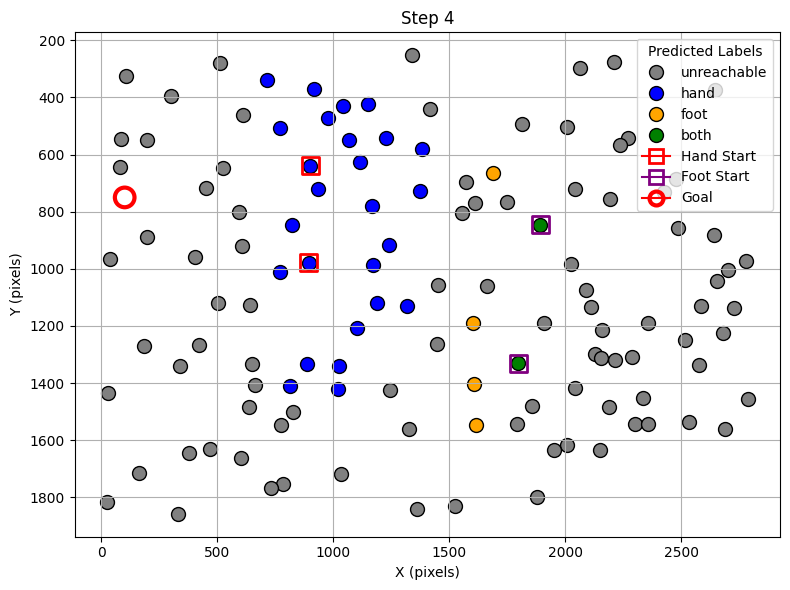

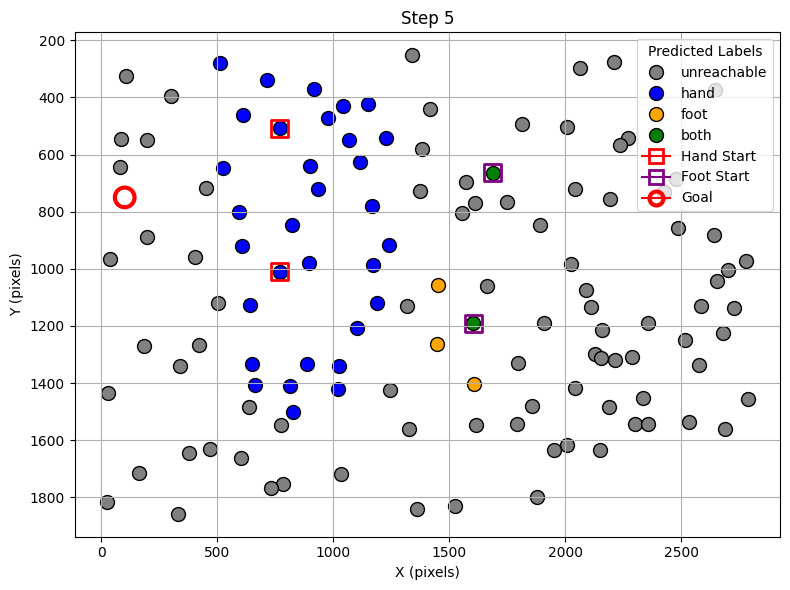

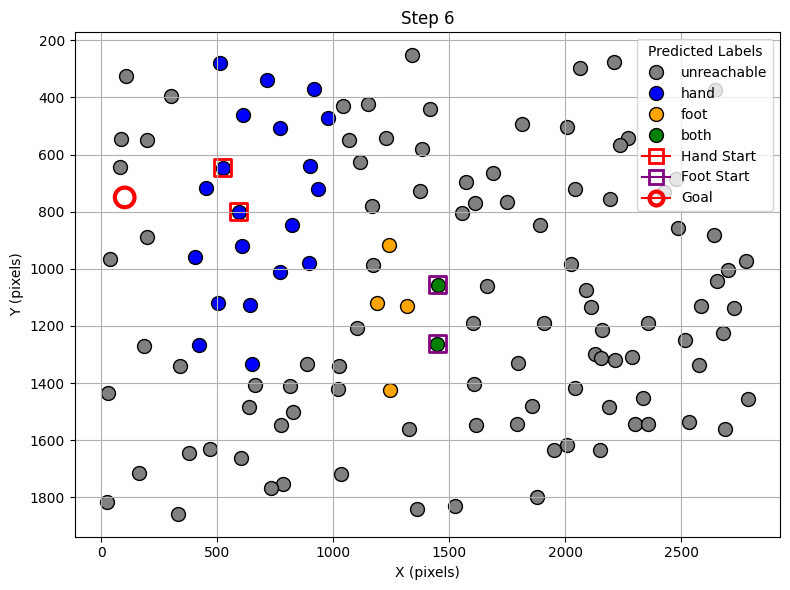

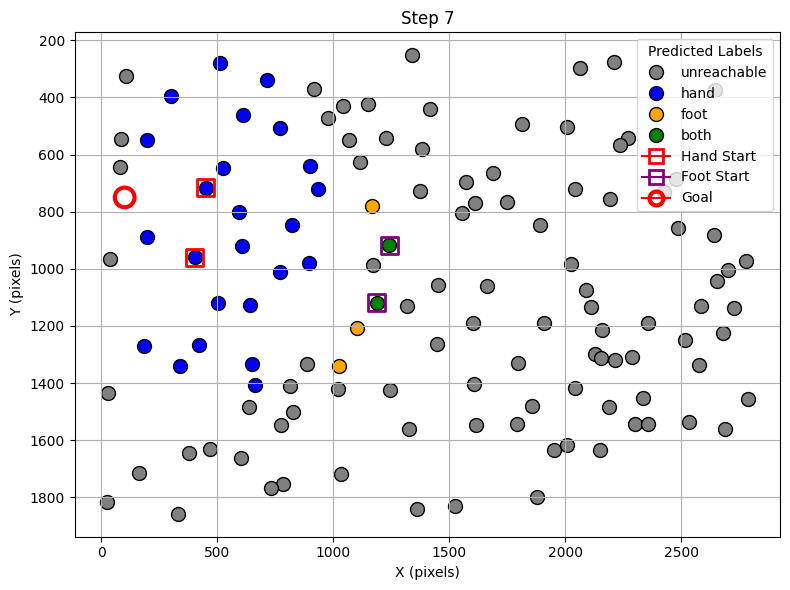

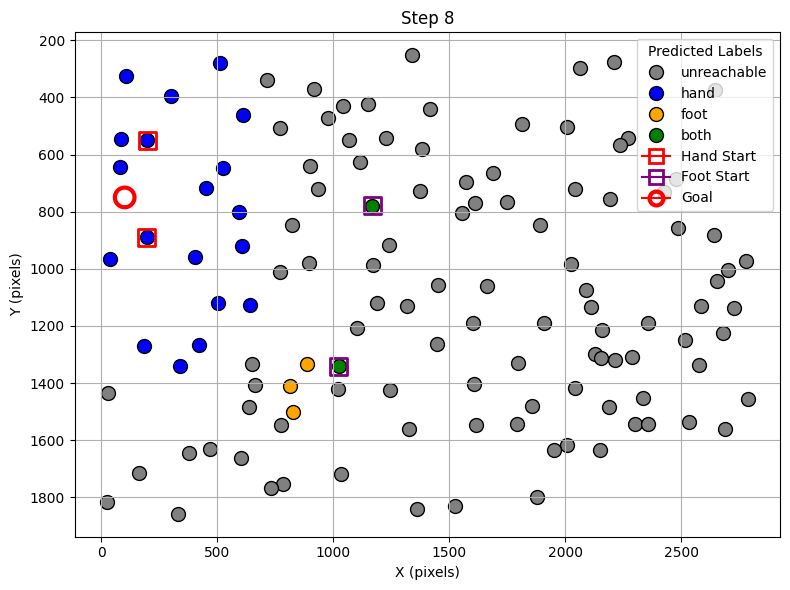

Success: goal reachable (label=1) at Step 8


In [10]:
simulate_climb_to_goal(batch, model, (100, 750))